In [4]:
!pip install --quiet kaggle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install --quiet nltk scikit-learn joblib tensorflow
import os
import string
import joblib
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
fake_df = pd.read_csv("/content/Fake.csv")
true_df = pd.read_csv("/content/True.csv")

fake_df['label'] = 1
true_df['label'] = 0

# Use only 'text' and 'label'
df = pd.concat([fake_df[['text', 'label']], true_df[['text', 'label']]], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [7]:
def clean_text(text):
    text = str(text).lower()
    text = ''.join(ch for ch in text if ch not in string.punctuation)
    tokens = [w for w in text.split() if w not in STOPWORDS]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

In [8]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print("\nTraining Classical ML Models...")

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Training Classical ML Models...


In [10]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)
print("\nLogistic Regression:\n", classification_report(y_test, y_pred_lr))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4270
           1       0.99      0.98      0.99      4710

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [11]:
svm = SVC(kernel='linear')

svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)
print("\nSupport Vector Machine:\n", classification_report(y_test, y_pred_svm))


Support Vector Machine:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4270
           1       1.00      0.99      0.99      4710

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test_tfidf)

# Evaluate
acc_rf = accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Classifier:\n", classification_report(y_test, y_pred_rf))
print(f"Random Forest Accuracy: {acc_rf:.4f}")


Random Forest Classifier:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4270
           1       1.00      1.00      1.00      4710

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Random Forest Accuracy: 0.9976


In [12]:
print("\nPreparing for Deep Learning models...")

max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)


Preparing for Deep Learning models...


In [13]:
cnn = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.fit(X_train_seq, y_train, epochs=1, batch_size=64, validation_split=0.2)

loss_cnn, acc_cnn = cnn.evaluate(X_test_seq, y_test)
print(f"\nCNN Accuracy: {acc_cnn:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 66ms/step - accuracy: 0.8414 - loss: 0.3278 - val_accuracy: 0.9845 - val_loss: 0.0430
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9825 - loss: 0.0482

CNN Accuracy: 0.9829


In [14]:
lstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.fit(X_train_seq, y_train, epochs=1, batch_size=64, validation_split=0.2)

loss_lstm, acc_lstm = lstm.evaluate(X_test_seq, y_test)
print(f"\nLSTM Accuracy: {acc_lstm:.4f}")


449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 163ms/step - accuracy: 0.9069 - loss: 0.2333 - val_accuracy: 0.9868 - val_loss: 0.0442
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9818 - loss: 0.0549

LSTM Accuracy: 0.9834


In [20]:
model_names = ['Logistic Regression', 'SVM', 'CNN', 'LSTM']
accuracies = [lr, svm,cnn, lstm]

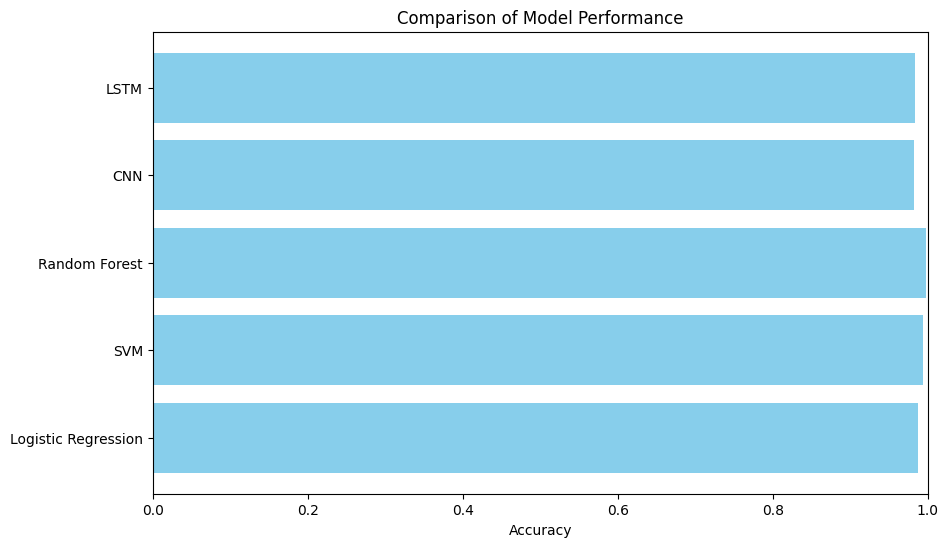

In [25]:
from sklearn.metrics import accuracy_score


acc_lr  = accuracy_score(y_test, y_pred_lr)
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_rf  = accuracy_score(y_test, y_pred_rf)


model_names = ['Logistic Regression', 'SVM', 'Random Forest', 'CNN', 'LSTM']
accuracies  = [acc_lr, acc_svm, acc_rf, acc_cnn, acc_lstm]


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Comparison of Model Performance')
plt.xlim(0, 1)
plt.show()


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def get_metrics(y_true, y_pred, name):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

results = [
    get_metrics(y_test, y_pred_lr, "Logistic Regression"),
    get_metrics(y_test, y_pred_svm, "SVM"),
    get_metrics(y_test, y_pred_rf, "Random Forest")
]


y_pred_cnn = (cnn.predict(X_test_seq) > 0.5).astype(int)
y_pred_lstm = (lstm.predict(X_test_seq) > 0.5).astype(int)

results.append(get_metrics(y_test, y_pred_cnn, "CNN"))
results.append(get_metrics(y_test, y_pred_lstm, "LSTM"))


results_df = pd.DataFrame(results)
results_df = results_df.round(4)
print("\n📊 Model Comparison Table:")
display(results_df)


281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step

📊 Model Comparison Table:


,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.9872,0.9917,0.9839,0.9877
1,SVM,0.9937,0.9957,0.9921,0.9939
2,Random Forest,0.9976,0.9983,0.9970,0.9977
3,CNN,0.9829,0.9876,0.9796,0.9836
4,LSTM,0.9834,0.9835,0.9849,0.9842


In [30]:
import joblib
import os


os.makedirs('/content/output', exist_ok=True)


joblib.dump(rf, '/content/output/fake_news_model.pkl')


joblib.dump(vectorizer, '/content/output/vectorizer.pkl')

print("✅ Model and vectorizer saved to /content/output/")


✅ Model and vectorizer saved to /content/output/


In [31]:

!zip -r /content/output/fake_news_package.zip /content/output


from google.colab import files
files.download('/content/output/fake_news_package.zip')


  adding: content/output/ (stored 0%)
  adding: content/output/fake_news_model.pkl (deflated 78%)
  adding: content/output/vectorizer.pkl (deflated 66%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>